In [2]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
import os
from pathlib import Path
import itertools
import pickle
import seaborn as sns
import jax
import jax.numpy as np
import numpy
import scipy
import seaborn as sns
jax.config.update('jax_platform_name', 'cpu')
os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=16'

In [4]:
from sklearn.cluster import MiniBatchKMeans
seed = 42

In [5]:
from bomtemplate.bd_transformation import fc_phases_space, fc_space, activity_space
from bomtemplate.into_states import clustering
from bomtemplate.reliability_assessment import fingerprinting, predictive_power
from bomtemplate import utility
from bomtemplate import bd_preprocessing

In [6]:
cwd = os.getcwd()
head = Path(cwd).parents[2]
path_data = os.path.join(head, 'saved_data/')

In [7]:
path_figures = os.path.join(head, 'figures/emp/pepr_April2024')
path_figures

'/home/anastasios/Marseille/projects/brain_screening/figures/emp/pepr_April2024'

In [8]:
getdata = bd_preprocessing.Get_1000Brains_Data(path_data)
output_dict = getdata.get_data(bins=False)
output_dict.keys()

dict_keys(['data_3d', 'ages', 'TR', 'transient'])

In [9]:
transient = output_dict['transient']
data_3d = output_dict['data_3d'][:,transient:]
n_participants, n_samples, n_nodes = data_3d.shape

In [10]:
lowcut = 0.01
highcut = 0.08
data_3d_filtered = numpy.zeros_like(data_3d)
for p in range(n_participants):
    data_3d_filtered [p] = bd_preprocessing.butter_bandpass_filter(data_3d[p], axis=0, lowcut=lowcut, highcut=highcut, fs=1, order=1)

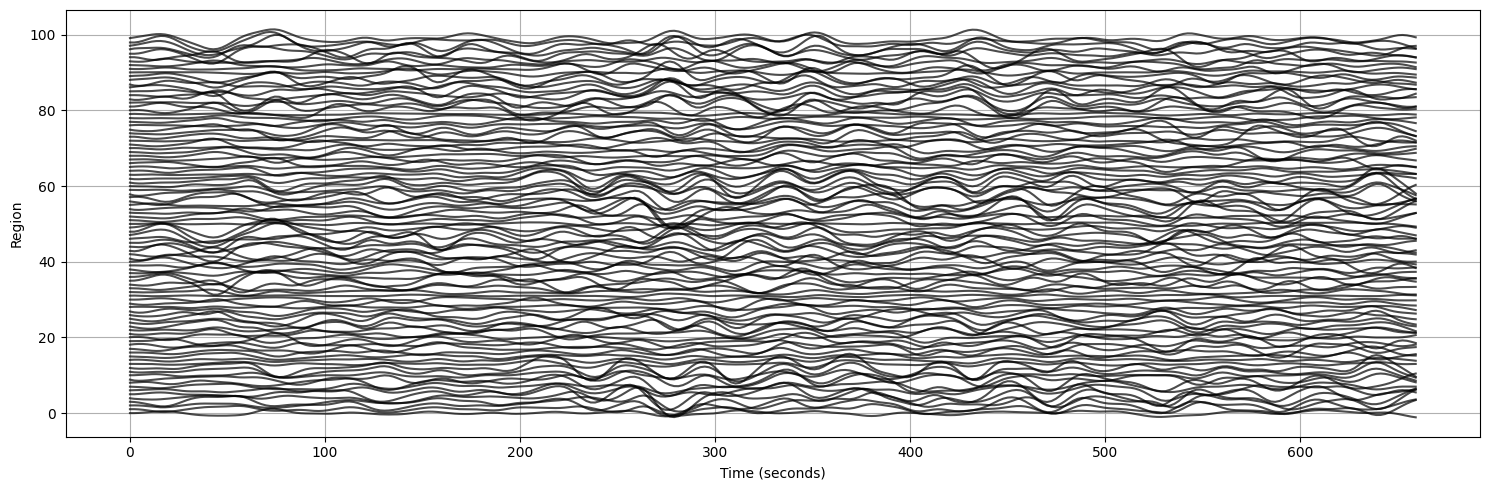

In [11]:
TR = output_dict['TR']
bd_preprocessing.plot_filtered_ts(data_3d_filtered[9], TR=TR)

### thresholded data, like chinese paper

#### step 1: transform the data

In [12]:
h=30

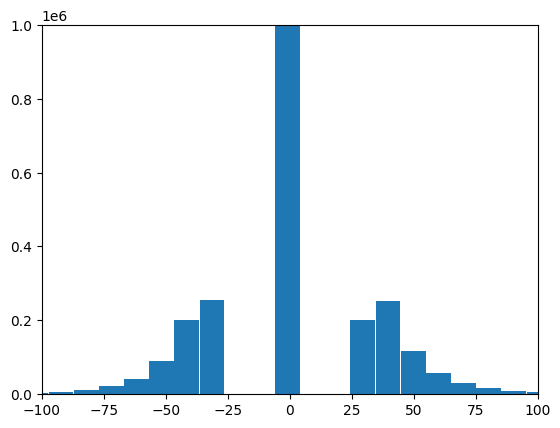

In [13]:
est_thr = activity_space.Thresholding().fit(X = data_3d)
data_thr = est_thr.transform(data_3d, threshold=h)
counts, edges = np.histogram(data_thr.ravel(), bins=200)
centers = (edges[1:]+ edges[:-1])/2
bar(centers, counts, width=10)
ylim(0,1e6)
xlim(-100,100);

#### step 2: cluster into recurrent objects (states)

In [14]:
n_states = 5
part = getdata.split_test_retest(removed_transient=1)
xtest = data_thr[:,:part]
xretest = data_thr[:,-part:]

In [15]:
xtest.shape, xretest.shape

((648, 133, 100), (648, 133, 100))

In [16]:
k = clustering.Cluster()
kmeans = MiniBatchKMeans(n_clusters=n_states, n_init='auto', random_state=seed)
xtest = xtest.reshape(-1, n_nodes)
xretest = xretest.reshape(-1, n_nodes)
k.fit(xtest, kmeans)
X  = k.predict(xtest).reshape(n_participants,-1)
y  = k.predict(xretest).reshape(n_participants,-1)


#### step 3: reliability assessment

In [17]:
fp = fingerprinting.Fingerprinting()
fp.fit(X, y)
Xor, yor = fp.transform(X, y)

In [18]:
permst, obsst, pv = fp.score_intrasim_vs_intrasim(num_permutations=1000)

100%|██████████| 1000/1000 [00:00<00:00, 2548.79it/s]


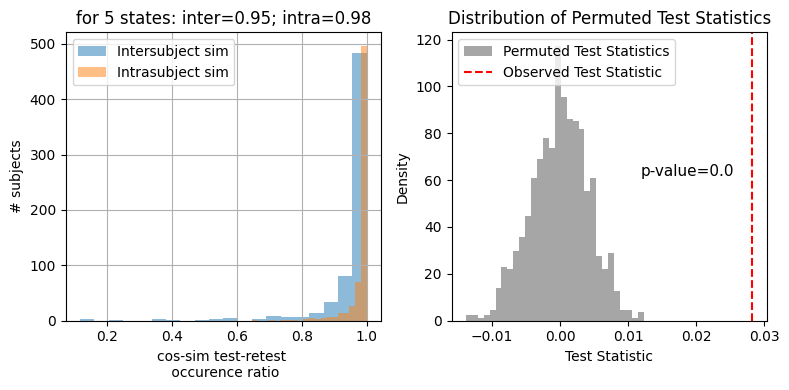

In [19]:
figure(figsize=(8,4))
subplot(121)
hist(fp.intersim, 20, label='Intersubject sim', alpha=0.5)
hist(fp.intrasim, 20, label='Intrasubject sim', alpha=0.5)
xlabel('cos-sim test-retest \n occurence ratio'); ylabel('# subjects'); grid(1);
title(f'for {n_states} states: inter={fp.intersim.mean():0.2f}; intra={fp.intrasim.mean():0.2f}')
legend()
subplot(122)
hist(permst, bins=30, density=True, alpha=0.7, color='grey', label='Permuted Test Statistics')
axvline(x=obsst, color='red', linestyle='--', label='Observed Test Statistic')
annotate(rf'p-value={pv}',
                   xy=(0.6, 0.5), xycoords='axes fraction', fontsize=11)
xlabel('Test Statistic')
ylabel('Density')
title('Distribution of Permuted Test Statistics')
legend()
tight_layout()
savefig(os.path.join(path_figures, 'fp_Thresh.png'), dpi=250, bbox_inches='tight')

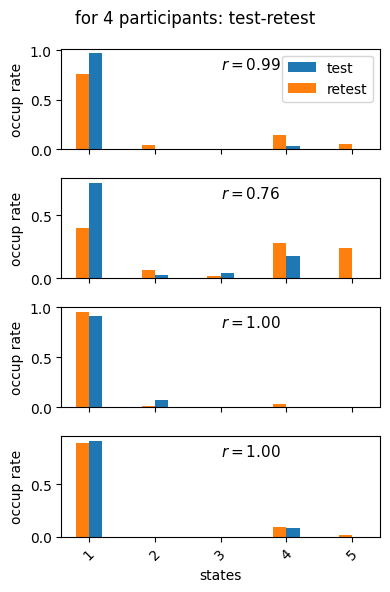

In [20]:
vor_corcoefs = np.zeros((n_participants))
for p in range(n_participants):
    vor_corcoefs = vor_corcoefs.at[p].set(np.corrcoef(fp.X_[p,:], fp.y_[p,:])[0,1])
x = np.arange(fp.n_states)
width=0.2
f, ax = plt.subplots(4,1,#4 subjects
                     sharex='col', sharey='row', figsize=(4,6))
for p in range(4): 
    ax[p].bar(x+width/2, fp.X_[p,:], width=width, label='test')
    ax[p].bar(x-width/2, fp.y_[p,:], width=width, label='retest')
    ax[p].set_xticks(x,x+1, rotation=45)
    ax[p].annotate(rf'$r={vor_corcoefs[p].round(3):0.02f}$', xy=(0.5, 0.8), xycoords='axes fraction', fontsize=11)
    ax[-1].set_xlabel('states')
    ax[p].set_ylabel('occup rate')
ax[0].legend()
f.suptitle('for 4 participants: test-retest')
plt.tight_layout();
savefig(os.path.join(path_figures, 'fp_cor_Thresh.png'), dpi=250, bbox_inches='tight')

#### step 4: predictive power

In [21]:
train_idx, test_idx = getdata.split_train_test()

In [22]:
xtrain = data_thr[train_idx].copy()
xtest = data_thr[test_idx].copy()

In [23]:
k = clustering.Cluster()
kmeans = MiniBatchKMeans(n_clusters=n_states, n_init='auto', random_state=seed)
xtrain = xtrain.reshape(-1, n_nodes)
xtest = xtest.reshape(-1, n_nodes)
k.fit(xtrain, kmeans)
trlab_grouped  = k.predict(xtrain).reshape(train_idx.size,-1)
telab_grouped  = k.predict(xtest).reshape(test_idx.size,-1)

In [24]:
f = fingerprinting.Fingerprinting()
f.fit(trlab_grouped, telab_grouped);
tror, teor = f.transform(trlab_grouped, telab_grouped)
ages = output_dict["ages"]

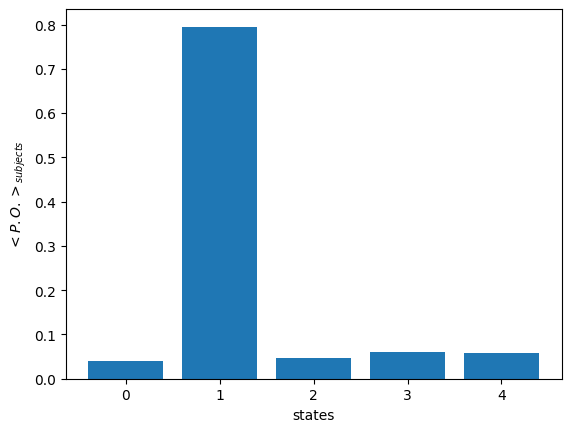

In [25]:
bar(np.r_[0:n_states], tror.mean(0))
xlabel('states')
ylabel(r'$<P.O.>_{subjects}$')
savefig(os.path.join(path_figures, 'PO_mean_Thresh.png'), dpi=250, bbox_inches='tight')

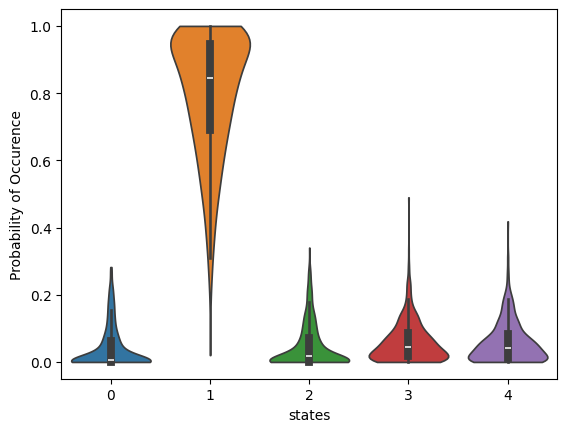

In [26]:
sns.violinplot(tror, cut=0, inner='box')
xlabel('states')
ylabel('Probability of Occurence')
savefig(os.path.join(path_figures, 'PO_Thresh.png'), dpi=250, bbox_inches='tight')
# savefig(os.path.join(path_figures, 'PO_Zudah.png'), dpi=250, bbox_inches='tight')

In [27]:
pp = predictive_power.Predict()
y = ages[train_idx]
pp.fit(tror, y)

Predict()

In [28]:
predictors, r_values, p_values = pp.predict(teor, ages[test_idx])
r_values, p_values

(0.005666998792740161, 0.9485799824794381)

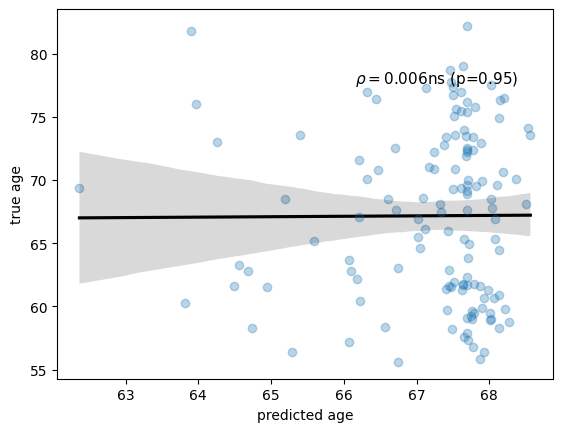

In [29]:
y = predictors#[-1,:]
sns.regplot(x=y, y=ages[test_idx],
            line_kws=dict(color="k",zorder=0), ci=95, scatter_kws={"alpha": 0.3})
slope,_,r_value,p_value,_ = scipy.stats.linregress(x=y, y=ages[test_idx])
annotate(rf'$\rho={r_value.round(3)}${utility.convert_pvalue_to_asterisks(p_value)} (p={p_value:0.02f})',
         xy=(0.6, 0.8), xycoords='axes fraction', fontsize=11)
ylabel('true age'), xlabel('predicted age')
savefig(os.path.join(path_figures, 'pp_Thresh.png'), dpi=250, bbox_inches='tight')

**Note:** which is  subject to the initialization of the kmeans

### Zudah

#### step 1: transform the data

In [30]:
est_zudah = fc_phases_space.Zudah().fit(X=data_3d_filtered)
zudah = est_zudah.transform(data_3d_filtered)

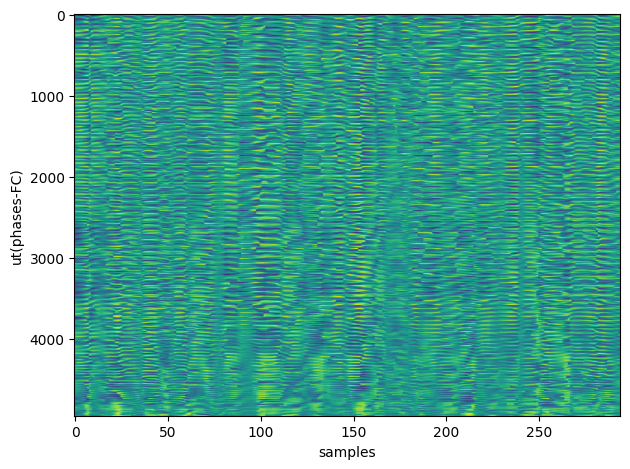

In [54]:
imshow(zudah[0].T, aspect='auto')
ylabel('ut(phases-FC)')
xlabel('samples')
tight_layout()
savefig(os.path.join(path_figures, 'Zudah/PO_Zudah.png'), dpi=250, bbox_inches='tight')
show()

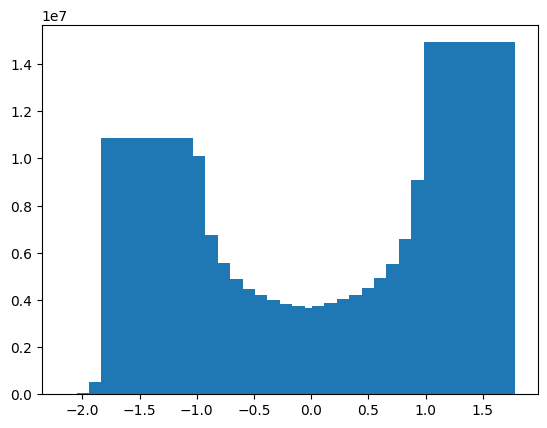

In [31]:
c, e = np.histogram(zudah[:100].flatten(), 30)
xt = (e[1:]+e[:-1])/2
bar(xt, c)
n_states = 5
n_features = est_zudah.n_features

In [32]:
k = clustering.Cluster()
kmeans = MiniBatchKMeans(n_clusters=n_states, n_init='auto',random_state=seed)
data = zudah.reshape(-1, est_zudah.n_features)
k.fit(data, kmeans)
X  = k.predict(data).reshape(n_participants,-1)

In [33]:
data_or = jax.vmap(fingerprinting.labels2occup, in_axes=(0, None))(X, n_states)

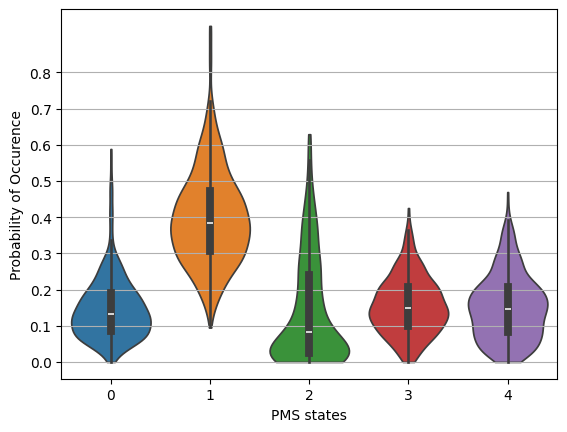

In [34]:
sns.violinplot(data_or, cut=0, inner='box')
xlabel('PMS states')
ylabel('Probability of Occurence')
yticks(np.r_[0:data_or.max().round(1):0.1])
grid(axis='y')
savefig(os.path.join(path_figures, 'PO_Zudah.png'), dpi=250, bbox_inches='tight')

Text(0, 0.5, '$<P.O.>_{subjects}$')

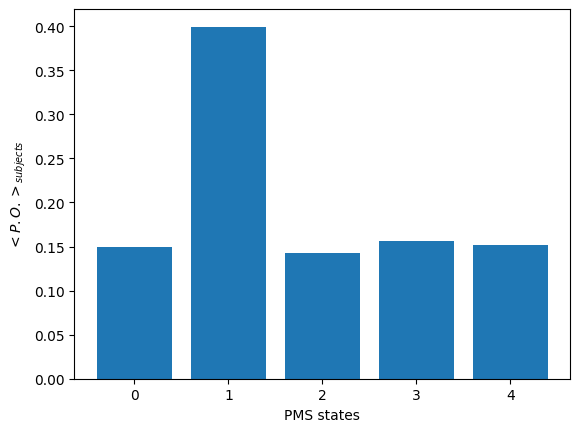

In [35]:
bar(np.r_[0:n_states], data_or.mean(0))
xlabel('PMS states')
ylabel(r'$<P.O.>_{subjects}$')
# savefig(os.path.join(path_figures, 'PO_mean_Zudah.png'), dpi=250, bbox_inches='tight')

#### step 2: cluster into recurrent objects (states)

In [36]:
n_states = 5
xtest = zudah[:,:part].copy()
xretest = zudah[:,-part:].copy()

In [37]:
xretest.shape

(648, 133, 4950)

In [38]:
k = clustering.Cluster()
kmeans = MiniBatchKMeans(n_clusters=n_states, n_init='auto',random_state=seed)
xtest = xtest.reshape(-1, est_zudah.n_features)
xretest = xretest.reshape(-1, est_zudah.n_features)
k.fit(xtest, kmeans)
X  = k.predict(xtest).reshape(n_participants,-1)
y  = k.predict(xretest).reshape(n_participants,-1)


#### step 3: reliability assessment

In [39]:
fp = fingerprinting.Fingerprinting()
fp.fit(X, y)
Xor, yor = fp.transform(X, y)

In [40]:
Xor.shape

(648, 5)

In [41]:
permst, obsst, pv = fp.score_intrasim_vs_intrasim(num_permutations=1000)

100%|██████████| 1000/1000 [00:00<00:00, 3629.08it/s]


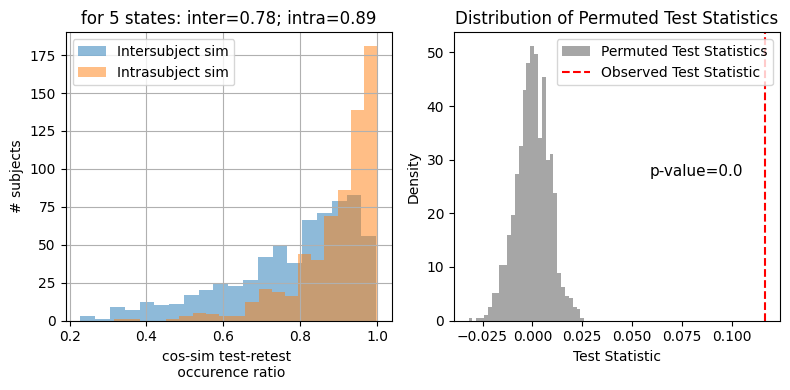

In [42]:
figure(figsize=(8,4))
subplot(121)
hist(fp.intersim, 20, label='Intersubject sim', alpha=0.5)
hist(fp.intrasim, 20, label='Intrasubject sim', alpha=0.5)
xlabel('cos-sim test-retest \n occurence ratio'); ylabel('# subjects'); grid(1);
title(f'for {n_states} states: inter={fp.intersim.mean():0.2f}; intra={fp.intrasim.mean():0.2f}')
legend()
subplot(122)
hist(permst, bins=30, density=True, alpha=0.7, color='grey', label='Permuted Test Statistics')
axvline(x=obsst, color='red', linestyle='--', label='Observed Test Statistic')
annotate(rf'p-value={pv}',
                   xy=(0.6, 0.5), xycoords='axes fraction', fontsize=11)
xlabel('Test Statistic')
ylabel('Density')
title('Distribution of Permuted Test Statistics')
legend()
tight_layout()
savefig(os.path.join(path_figures, 'fp_Zudah.png'), dpi=250, bbox_inches='tight')

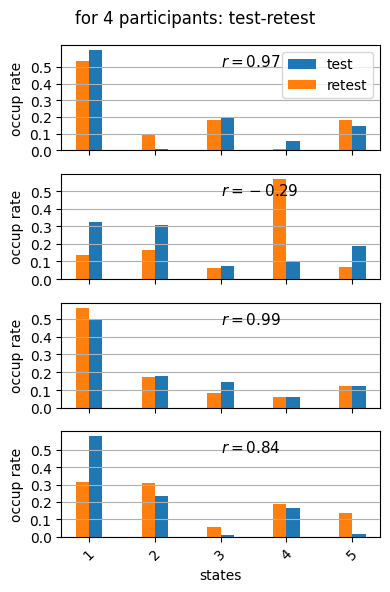

In [50]:
vor_corcoefs = np.zeros((n_participants))
for p in range(n_participants):
    vor_corcoefs = vor_corcoefs.at[p].set(np.corrcoef(fp.X_[p,:], fp.y_[p,:])[0,1])
x = np.arange(fp.n_states)
width=0.2
f, ax = plt.subplots(4,1,#4 subjects
                     sharex='col', sharey='row', figsize=(4,6))
for p in range(4): 
    ax[p].bar(x+width/2, fp.X_[p,:], width=width, label='test')
    ax[p].bar(x-width/2, fp.y_[p,:], width=width, label='retest')
    ax[p].set_xticks(x,x+1, rotation=45)
    ymaxtick = np.hstack((fp.y_[p,:], fp.X_[p,:])).max()
    ax[p].set_yticks(np.r_[0:ymaxtick.round(1):0.1])
    ax[p].annotate(rf'$r={vor_corcoefs[p].round(3):0.02f}$', xy=(0.5, 0.8), xycoords='axes fraction', fontsize=11)
    ax[-1].set_xlabel('states')
    ax[p].set_ylabel('occup rate')
    ax[p].grid(axis='y')
ax[0].legend()
f.suptitle('for 4 participants: test-retest')
tight_layout();
# savefig(os.path.join(path_figures, 'fp_cor_Zudah.png'), dpi=250, bbox_inches='tight')

#### step 4: predictive power

In [44]:
xtrain = zudah[train_idx].copy()
xtest = zudah[test_idx].copy()

In [45]:
k = clustering.Cluster()
kmeans = MiniBatchKMeans(n_clusters=n_states, n_init='auto', random_state=42)
xtrain = xtrain.reshape(-1, n_features)
xtest = xtest.reshape(-1, n_features)
k.fit(xtrain, kmeans)
trlab_grouped  = k.predict(xtrain).reshape(train_idx.size,-1)
telab_grouped  = k.predict(xtest).reshape(test_idx.size,-1)

In [46]:
f = fingerprinting.Fingerprinting()
f.fit(trlab_grouped, telab_grouped);
tror, teor = f.transform(trlab_grouped, telab_grouped)
ages = output_dict["ages"]

In [47]:
pp = predictive_power.Predict()
y = ages[train_idx]
pp.fit(tror, y)
predictors, r_values, p_values = pp.predict(teor, ages[test_idx])
r_values, p_values

(0.17189803311769797, 0.048738759553297796)

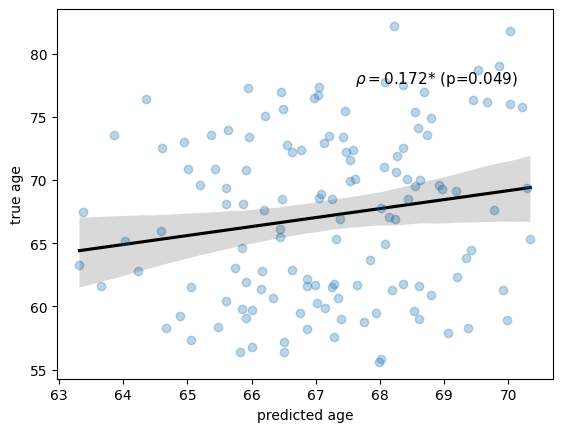

In [48]:
y = predictors#[-1,:]
sns.regplot(x=y, y=ages[test_idx],
            line_kws=dict(color="k",zorder=0), ci=95, scatter_kws={"alpha": 0.3})
slope,_,r_value,p_value,_ = scipy.stats.linregress(x=y, y=ages[test_idx])
annotate(rf'$\rho={r_value.round(3)}${utility.convert_pvalue_to_asterisks(p_value)} (p={p_value:0.03f})',
         xy=(0.6, 0.8), xycoords='axes fraction', fontsize=11)
ylabel('true age'), xlabel('predicted age')
# savefig(os.path.join(path_figures, 'pp_Zudah.png'), dpi=250, bbox_inches='tight')

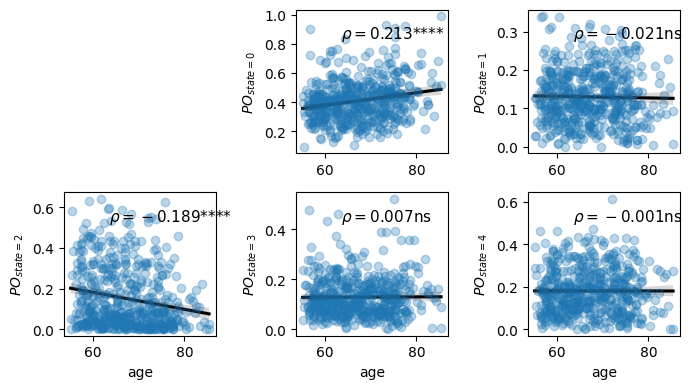

In [49]:
b =  ages[train_idx]
figure(figsize=(7,4))
for i in range(n_states):
    y = tror[:,i]
    subplot(2,3,i+2)
    sns.regplot(x=b, y=y,
                line_kws=dict(color="k",zorder=0), ci=95, scatter_kws={"alpha": 0.3})
    slope,_,r_value,p_value,_ = scipy.stats.linregress(x=b, y=y)
    annotate(rf'$\rho={r_value.round(3)}${utility.convert_pvalue_to_asterisks(p_value)}',
            xy=(0.3, 0.8), xycoords='axes fraction', fontsize=11)
    ylabel(f'$PO_{{state={i}}}$')
    if i>1:
        xlabel('age')
tight_layout()
# savefig(os.path.join(path_figures, 'pp_perstate_Zudah.png'), dpi=250, bbox_inches='tight')